# Setup

## Imports

In [200]:
using Pkg
Pkg.activate("SCC", shared=true)

import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

  Activating project at `~/.julia/environments/SCC`


## Logger Setups

In [201]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

MiniLogger{MiniLoggers.Squash, IJulia.IJuliaStdio{Base.PipeEndpoint}, IJulia.IJuliaStdio{Base.PipeEndpoint}, DateFormat{Symbol("yyyy-mm-dd HH:MM:SS"), Tuple{Dates.DatePart{'y'}, Dates.Delim{Char, 1}, Dates.DatePart{'m'}, Dates.Delim{Char, 1}, Dates.DatePart{'d'}, Dates.Delim{Char, 1}, Dates.DatePart{'H'}, Dates.Delim{Char, 1}, Dates.DatePart{'M'}, Dates.Delim{Char, 1}, Dates.DatePart{'S'}}}, typeof(string)}(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(38) open, 0 bytes waiting))), IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), Error, LogLevel(-1), Dict{Any, Int64}(), true, MiniLoggers.Token[MiniLoggers.Token("[", MiniLoggers.Color(-1, false)), MiniLoggers.Token("timestamp", MiniLoggers.Color(:func, false)), MiniLoggers.Token("] ", MiniLoggers.Color(-1, false)), MiniLoggers.Token("level", MiniLoggers.Color(:func, false)), MiniLoggers.Token(": ", MiniLoggers.Color(-1, false)), MiniLoggers.Token("message", M

# Loading Model and json

In [206]:
Mode35 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3and5/Mode3and5.json");

device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

In [207]:
proj_dict = SC.Utils.Get_Projection_Ops(Mode35.dressed_states);

In [208]:
GLOBAL_SAVE_CALIBRATE = true;

In [255]:
SC.Utils.save_model(Mode35)

# Calibrating Pulses

## Qubit Pulses

### Guasisan g -> e

In [158]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ge"]["sigma"]))

Target σ: 0.023251488095238096


#### Getting Stark Shift

[2024-12-09 19:14:33] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:01:53


[2024-12-09 19:16:27] Info: Done With Floquet Sweep
[2024-12-09 19:16:27] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0003609116698058171	 0.00895206229154316	 2.0067299824778098


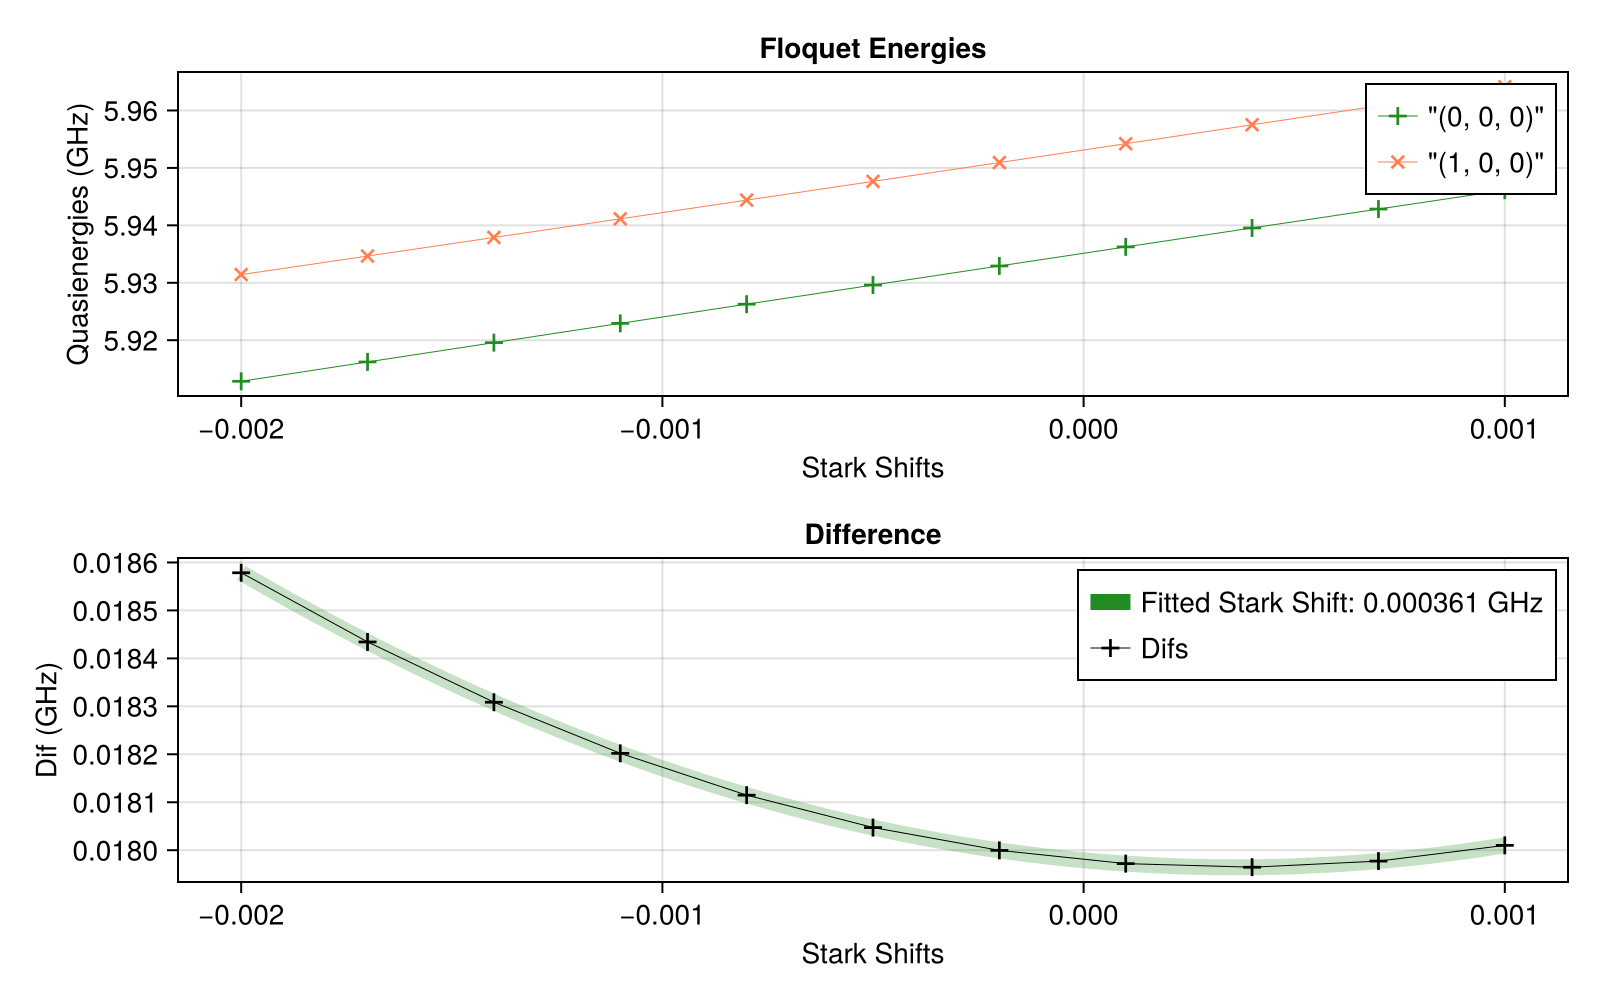

Stark shift res: [0.0003609116698058171, 55.66573720639071]


In [159]:
ge_ε = 0.00538
drive_op = Mode35.n̂ₜ
state1 = (0,0,0)
state2 = (1,0,0)

stark_shift_list = collect(LinRange(-0.002, 0.001, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode35, state1, state2, ge_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))
ge_stark_shift = stark_shift_res[1];

#### $\ket{0,0,0}\to\ket{1,0,0}$

In [160]:
state1 = (0,0,0)
state2 = (1,0,0)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ge_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ge00_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ge_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 19:16:27] Info: On Level 1
[2024-12-09 19:16:27] Info: On Step 1: t = 90.0
[2024-12-09 19:16:27] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 12s (ETA: 0h 00m 00s)
[2024-12-09 19:16:39] Info: Time Evolution Complete
[2024-12-09 19:16:39] Info: Done with Level_1_step_1
[2024-12-09 19:16:39] Info: Accurace: 0.9966876212661196
[2024-12-09 19:16:39] Info: ------------------------------------------------------------------------------
[2024-12-09 19:16:39] Info: On Step 2: t = 92.5
[2024-12-09 19:16:39] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 12s (ETA: 0h 00m 00s)
[2024-12-09 19:16:52] Info: Time Evolution Complete
[2024-12-09 19:16:52] Info: Done with Level_1_step_2
[2024-12-09 19:16:52] Info: Accurace: 0.9991655142261663
[2024-12-09 19:16:52] Info: ------------------------------------------------------------------------------
[2024-12-09 19:16:52] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.99924
  "freq_d"        => 4.60215

In [161]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ge_0"] = deepcopy(qubit_ge00_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.99924
  "freq_d"        => 4.60215

#### $\ket{0,1,0}\to\ket{1,1,0}$

In [162]:
state1 = (0,1,0)
state2 = (1,1,0)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ge_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ge10_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ge_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 19:21:59] Info: On Level 1
[2024-12-09 19:21:59] Info: On Step 1: t = 90.0
[2024-12-09 19:21:59] Info: Running Time Evolution


Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 19:22:12] Info: Time Evolution Complete
[2024-12-09 19:22:12] Info: Done with Level_1_step_1
[2024-12-09 19:22:12] Info: Accurace: 0.997128673967923
[2024-12-09 19:22:12] Info: ------------------------------------------------------------------------------
[2024-12-09 19:22:12] Info: On Step 2: t = 92.5
[2024-12-09 19:22:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 19:22:26] Info: Time Evolution Complete
[2024-12-09 19:22:26] Info: Done with Level_1_step_2
[2024-12-09 19:22:26] Info: Accurace: 0.9996246342249145
[2024-12-09 19:22:26] Info: ------------------------------------------------------------------------------
[2024-12-09 19:22:26] Info: On Step 3: t = 95.0
[2024-12-09 19:22:26] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.999697
  "freq_d"        => 4.60195

In [163]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ge_10"] = deepcopy(qubit_ge10_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.999697
  "freq_d"        => 4.60195

#### $\ket{0,0,1}\to\ket{1,0,1}$

In [164]:
state1 = (0,0,1)
state2 = (1,0,1)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ge_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ge01_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ge_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 19:27:51] Info: On Level 1
[2024-12-09 19:27:51] Info: On Step 1: t = 90.0
[2024-12-09 19:27:51] Info: Running Time Evolution


Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 19:28:05] Info: Time Evolution Complete
[2024-12-09 19:28:05] Info: Done with Level_1_step_1
[2024-12-09 19:28:05] Info: Accurace: 0.997133109876672
[2024-12-09 19:28:05] Info: ------------------------------------------------------------------------------
[2024-12-09 19:28:05] Info: On Step 2: t = 92.5
[2024-12-09 19:28:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 14s (ETA: 0h 00m 00s)
[2024-12-09 19:28:19] Info: Time Evolution Complete
[2024-12-09 19:28:19] Info: Done with Level_1_step_2
[2024-12-09 19:28:19] Info: Accurace: 0.9996283442304619
[2024-12-09 19:28:19] Info: ------------------------------------------------------------------------------
[2024-12-09 19:28:19] Info: On Step 3: t = 95.0
[2024-12-09 19:28:19] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.999701
  "freq_d"        => 4.60198

In [165]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ge_01"] = deepcopy(qubit_ge01_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.999701
  "freq_d"        => 4.60198

#### $\ket{0,1,1}\to\ket{1,1,1}$

In [166]:
state1 = (0,1,1)
state2 = (1,1,1)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ge_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ge11_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ge_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 19:33:47] Info: On Level 1
[2024-12-09 19:33:47] Info: On Step 1: t = 90.0
[2024-12-09 19:33:47] Info: Running Time Evolution


Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 19:34:01] Info: Time Evolution Complete
[2024-12-09 19:34:01] Info: Done with Level_1_step_1
[2024-12-09 19:34:01] Info: Accurace: 0.9971378790085318
[2024-12-09 19:34:01] Info: ------------------------------------------------------------------------------
[2024-12-09 19:34:01] Info: On Step 2: t = 92.5
[2024-12-09 19:34:01] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 14s (ETA: 0h 00m 00s)
[2024-12-09 19:34:16] Info: Time Evolution Complete
[2024-12-09 19:34:16] Info: Done with Level_1_step_2
[2024-12-09 19:34:16] Info: Accurace: 0.9996376447285363
[2024-12-09 19:34:16] Info: ------------------------------------------------------------------------------
[2024-12-09 19:34:16] Info: On Step 3: t = 95.0
[2024-12-09 19:34:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.999711
  "freq_d"        => 4.60177

In [167]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ge_11"] = deepcopy(qubit_ge11_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.999711
  "freq_d"        => 4.60177

#### $\ket{0,2,1}\to\ket{1,2,1}$

In [168]:
state1 = (0,2,1)
state2 = (1,2,1)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ge_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ge21_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ge_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 19:39:41] Info: On Level 1
[2024-12-09 19:39:41] Info: On Step 1: t = 90.0
[2024-12-09 19:39:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 19:39:54] Info: Time Evolution Complete
[2024-12-09 19:39:55] Info: Done with Level_1_step_1
[2024-12-09 19:39:55] Info: Accurace: 0.9971333903611025
[2024-12-09 19:39:55] Info: ------------------------------------------------------------------------------
[2024-12-09 19:39:55] Info: On Step 2: t = 92.5
[2024-12-09 19:39:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 19:40:08] Info: Time Evolution Complete
[2024-12-09 19:40:08] Info: Done with Level_1_step_2
[2024-12-09 19:40:08] Info: Accurace: 0.9996373334403577
[2024-12-09 19:40:08] Info: ------------------------------------------------------------------------------
[2024-12-09 19:40:08] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.999711
  "freq_d"        => 4.60157

In [169]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ge_21"] = deepcopy(qubit_ge21_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.999711
  "freq_d"        => 4.60157

#### $\ket{0,1,2}\to\ket{1,1,2}$

In [170]:
state1 = (0,1,2)
state2 = (1,1,2)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ge_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ge12_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ge_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 20:00:12] Info: On Level 1
[2024-12-09 20:00:12] Info: On Step 1: t = 90.0
[2024-12-09 20:00:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 11s (ETA: 0h 00m 00s)
[2024-12-09 20:00:24] Info: Time Evolution Complete
[2024-12-09 20:00:24] Info: Done with Level_1_step_1
[2024-12-09 20:00:24] Info: Accurace: 0.9971342138318297
[2024-12-09 20:00:24] Info: ------------------------------------------------------------------------------
[2024-12-09 20:00:24] Info: On Step 2: t = 92.5
[2024-12-09 20:00:24] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 20:00:37] Info: Time Evolution Complete
[2024-12-09 20:00:37] Info: Done with Level_1_step_2
[2024-12-09 20:00:37] Info: Accurace: 0.9996374135965614
[2024-12-09 20:00:37] Info: ------------------------------------------------------------------------------
[2024-12-09 20:00:37] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.999711
  "freq_d"        => 4.60159

In [171]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ge_12"] = deepcopy(qubit_ge12_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.999711
  "freq_d"        => 4.60159

#### $\ket{0,2,2}\to\ket{1,2,2}$

In [172]:
state1 = (0,2,2)
state2 = (1,2,2)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ge_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ge22_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ge_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 20:05:49] Info: On Level 1
[2024-12-09 20:05:49] Info: On Step 1: t = 90.0
[2024-12-09 20:05:49] Info: Running Time Evolution


Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 20:06:02] Info: Time Evolution Complete
[2024-12-09 20:06:02] Info: Done with Level_1_step_1
[2024-12-09 20:06:02] Info: Accurace: 0.9971296450634454
[2024-12-09 20:06:02] Info: ------------------------------------------------------------------------------
[2024-12-09 20:06:02] Info: On Step 2: t = 92.5
[2024-12-09 20:06:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 20:06:16] Info: Time Evolution Complete
[2024-12-09 20:06:16] Info: Done with Level_1_step_2
[2024-12-09 20:06:16] Info: Accurace: 0.9996368261915715
[2024-12-09 20:06:16] Info: ------------------------------------------------------------------------------
[2024-12-09 20:06:16] Info: On Step 3: t = 95.0
[2024-12-09 20:06:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.999711
  "freq_d"        => 4.60139

In [173]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ge_22"] = deepcopy(qubit_ge22_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0.000360912
  "accuracy"      => 0.999711
  "freq_d"        => 4.60139

### Guasisan e -> f

In [174]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ef"]["sigma"]))

Target σ: 0.023251488095238096


#### Getting Stark Shift

[2024-12-09 20:11:39] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:02:00


[2024-12-09 20:13:39] Info: Done With Floquet Sweep
[2024-12-09 20:13:39] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00016543802245920793	 0.008954929708655919	 2.006374819729654


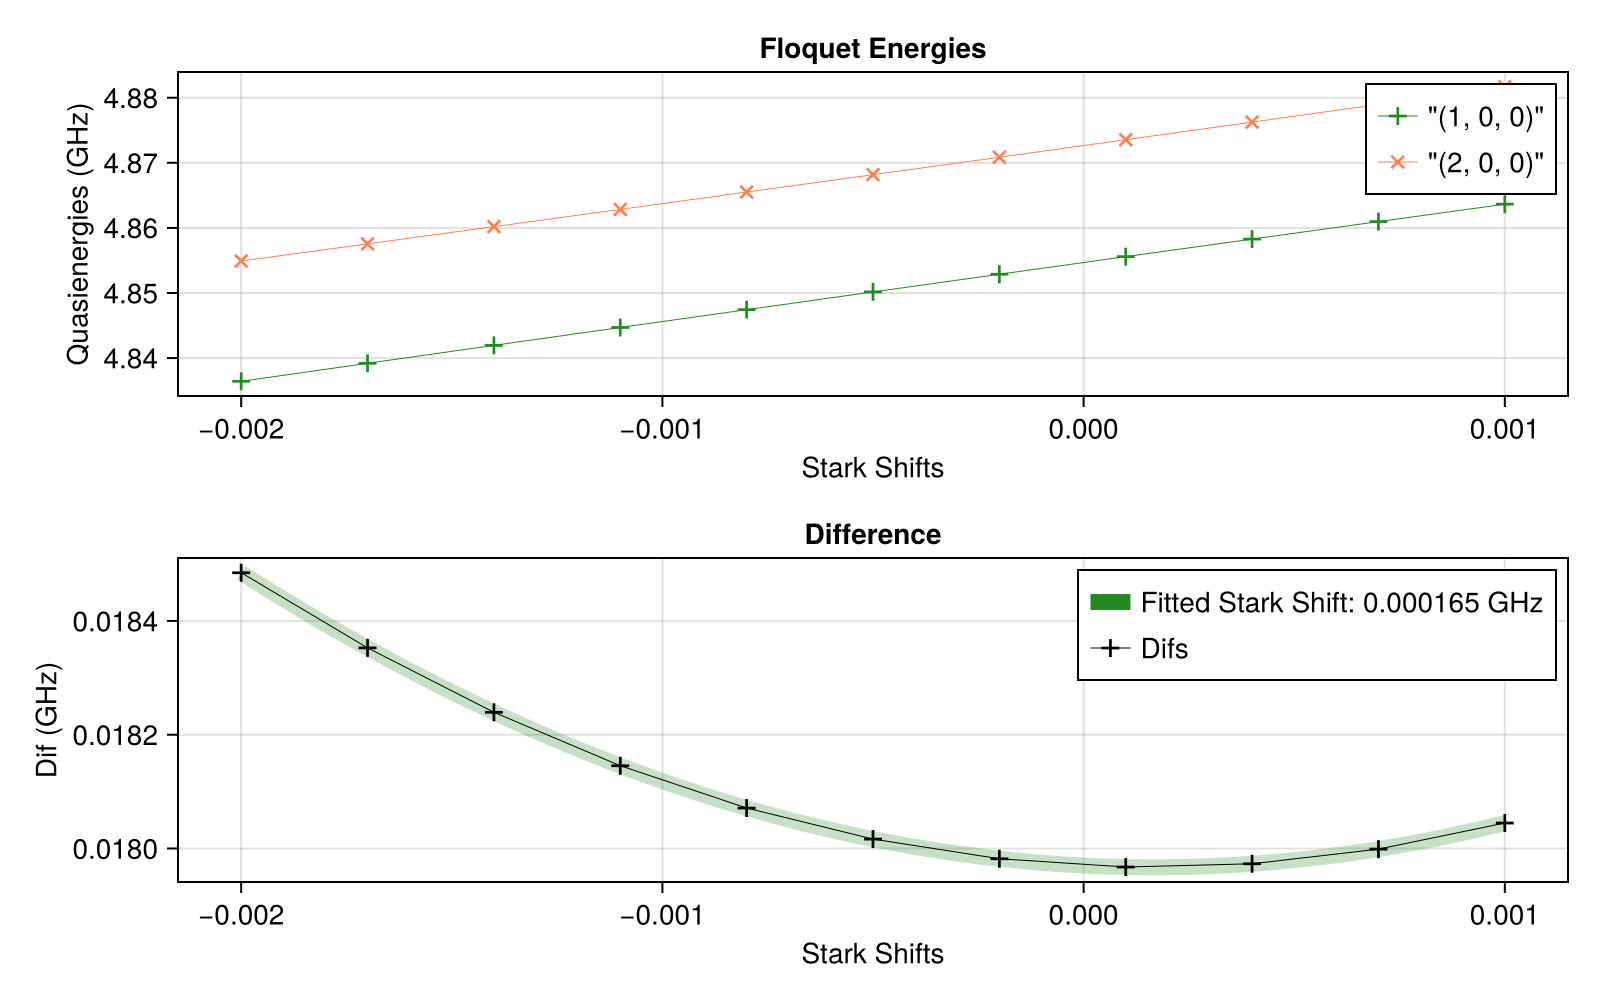

Stark shift res: [0.00016543802245920793, 55.657763369902256]


In [175]:
ef_ε = 0.00385
drive_op = Mode35.n̂ₜ
state1 = (1,0,0)
state2 = (2,0,0)

stark_shift_list = collect(LinRange(-0.002, 0.001, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode35, state1, state2, ef_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))
ef_stark_shift = stark_shift_res[1];

#### $\ket{1,0,0}\to\ket{2,0,0}$

In [176]:
state1 = (1,0,0)
state2 = (2,0,0)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ef_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ef00_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ef_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 20:13:39] Info: On Level 1
[2024-12-09 20:13:39] Info: On Step 1: t = 90.0
[2024-12-09 20:13:39] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 20:13:53] Info: Time Evolution Complete
[2024-12-09 20:13:53] Info: Done with Level_1_step_1
[2024-12-09 20:13:53] Info: Accurace: 0.9973079868500206
[2024-12-09 20:13:53] Info: ------------------------------------------------------------------------------
[2024-12-09 20:13:53] Info: On Step 2: t = 92.5
[2024-12-09 20:13:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 20:14:07] Info: Time Evolution Complete
[2024-12-09 20:14:07] Info: Done with Level_1_step_2
[2024-12-09 20:14:07] Info: Accurace: 0.9997869933285257
[2024-12-09 20:14:07] Info: ------------------------------------------------------------------------------
[2024-12-09 20:14:07] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999856
  "freq_d"        => 4.49411

In [177]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef00_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999856
  "freq_d"        => 4.49411

#### $\ket{1,1,0}\to\ket{2,1,0}$

In [178]:
state1 = (1,1,0)
state2 = (2,1,0)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ef_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ef10_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ef_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 20:19:30] Info: On Level 1
[2024-12-09 20:19:30] Info: On Step 1: t = 90.0
[2024-12-09 20:19:30] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 20:19:44] Info: Time Evolution Complete
[2024-12-09 20:19:44] Info: Done with Level_1_step_1
[2024-12-09 20:19:44] Info: Accurace: 0.9973417526392293
[2024-12-09 20:19:44] Info: ------------------------------------------------------------------------------
[2024-12-09 20:19:44] Info: On Step 2: t = 92.5
[2024-12-09 20:19:44] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 14s (ETA: 0h 00m 00s)
[2024-12-09 20:19:58] Info: Time Evolution Complete
[2024-12-09 20:19:58] Info: Done with Level_1_step_2
[2024-12-09 20:19:58] Info: Accurace: 0.9998231732085078
[2024-12-09 20:19:58] Info: ------------------------------------------------------------------------------
[2024-12-09 20:19:58] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999893
  "freq_d"        => 4.49393

In [179]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ef_10"] = deepcopy(qubit_ef10_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999893
  "freq_d"        => 4.49393

#### $\ket{1,0,1}\to\ket{2,0,1}$

In [180]:
state1 = (1,0,1)
state2 = (2,0,1)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ef_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ef01_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ef_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 20:25:24] Info: On Level 1
[2024-12-09 20:25:24] Info: On Step 1: t = 90.0
[2024-12-09 20:25:24] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 20:25:37] Info: Time Evolution Complete
[2024-12-09 20:25:37] Info: Done with Level_1_step_1
[2024-12-09 20:25:37] Info: Accurace: 0.9973426595645442
[2024-12-09 20:25:37] Info: ------------------------------------------------------------------------------
[2024-12-09 20:25:37] Info: On Step 2: t = 92.5
[2024-12-09 20:25:37] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 14s (ETA: 0h 00m 00s)
[2024-12-09 20:25:51] Info: Time Evolution Complete
[2024-12-09 20:25:51] Info: Done with Level_1_step_2
[2024-12-09 20:25:51] Info: Accurace: 0.9998235539012401
[2024-12-09 20:25:51] Info: ------------------------------------------------------------------------------
[2024-12-09 20:25:51] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999893
  "freq_d"        => 4.49395

In [181]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ef_01"] = deepcopy(qubit_ef01_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999893
  "freq_d"        => 4.49395

#### $\ket{1,1,1}\to\ket{2,1,1}$

In [182]:
state1 = (1,1,1)
state2 = (2,1,1)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ef_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ef11_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ef_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 20:31:20] Info: On Level 1
[2024-12-09 20:31:20] Info: On Step 1: t = 90.0
[2024-12-09 20:31:20] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 20:31:34] Info: Time Evolution Complete
[2024-12-09 20:31:34] Info: Done with Level_1_step_1
[2024-12-09 20:31:34] Info: Accurace: 0.9973406861229415
[2024-12-09 20:31:34] Info: ------------------------------------------------------------------------------
[2024-12-09 20:31:34] Info: On Step 2: t = 92.5
[2024-12-09 20:31:34] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 20:31:48] Info: Time Evolution Complete
[2024-12-09 20:31:48] Info: Done with Level_1_step_2
[2024-12-09 20:31:48] Info: Accurace: 0.9998235528905465
[2024-12-09 20:31:48] Info: ------------------------------------------------------------------------------
[2024-12-09 20:31:48] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999894
  "freq_d"        => 4.49377

In [183]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ef_11"] = deepcopy(qubit_ef11_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999894
  "freq_d"        => 4.49377

#### $\ket{1,2,1}\to\ket{2,2,1}$

In [184]:
state1 = (1,2,1)
state2 = (2,2,1)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ef_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ef21_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ef_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 20:37:11] Info: On Level 1
[2024-12-09 20:37:11] Info: On Step 1: t = 90.0


[2024-12-09 20:37:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 20:37:24] Info: Time Evolution Complete
[2024-12-09 20:37:24] Info: Done with Level_1_step_1
[2024-12-09 20:37:24] Info: Accurace: 0.9973376822364943
[2024-12-09 20:37:24] Info: ------------------------------------------------------------------------------
[2024-12-09 20:37:24] Info: On Step 2: t = 92.5
[2024-12-09 20:37:24] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 14s (ETA: 0h 00m 00s)
[2024-12-09 20:37:38] Info: Time Evolution Complete
[2024-12-09 20:37:38] Info: Done with Level_1_step_2
[2024-12-09 20:37:38] Info: Accurace: 0.9998226972376476
[2024-12-09 20:37:38] Info: ------------------------------------------------------------------------------
[2024-12-09 20:37:38] Info: On Step 3: t = 95.0
[2024-12-09 20:37:38] Info: Running Time Evolution
Progress: [========

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999894
  "freq_d"        => 4.49359

In [185]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ef_21"] = deepcopy(qubit_ef21_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999894
  "freq_d"        => 4.49359

#### $\ket{1,1,2}\to\ket{2,1,2}$

In [186]:
state1 = (1,2,1)
state2 = (2,2,1)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ef_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ef12_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ef_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 20:43:06] Info: On Level 1


[2024-12-09 20:43:06] Info: On Step 1: t = 90.0
[2024-12-09 20:43:06] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 20:43:20] Info: Time Evolution Complete
[2024-12-09 20:43:20] Info: Done with Level_1_step_1
[2024-12-09 20:43:20] Info: Accurace: 0.9973376822364943
[2024-12-09 20:43:20] Info: ------------------------------------------------------------------------------
[2024-12-09 20:43:20] Info: On Step 2: t = 92.5
[2024-12-09 20:43:20] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-09 20:43:33] Info: Time Evolution Complete
[2024-12-09 20:43:34] Info: Done with Level_1_step_2
[2024-12-09 20:43:34] Info: Accurace: 0.9998226972376476
[2024-12-09 20:43:34] Info: ------------------------------------------------------------------------------
[2024-12-09 20:43:34] Info: On Step 3: t = 95.0
[2024-12-09 20:43:34] 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999894
  "freq_d"        => 4.49359

In [187]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ef_12"] = deepcopy(qubit_ef12_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999894
  "freq_d"        => 4.49359

#### $\ket{1,2,2}\to\ket{2,2,2}$

In [188]:
state1 = (1,2,1)
state2 = (2,2,1)

ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2] - Mode35.dressed_energies[state1]
shift = ef_stark_shift
envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu" => 1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)

qubit_ef22_opt_res = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ef_ε, freq_d, shift, t_range, envelope, envelope_args, levels = 5)


[2024-12-09 21:26:53] Info: On Level 1
[2024-12-09 21:26:53] Info: On Step 1: t = 90.0
[2024-12-09 21:26:53] Info: Running Time Evolution


Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 23s (ETA: 0h 00m 00s)
[2024-12-09 21:27:17] Info: Time Evolution Complete
[2024-12-09 21:27:17] Info: Done with Level_1_step_1
[2024-12-09 21:27:17] Info: Accurace: 0.9973376822364943
[2024-12-09 21:27:17] Info: ------------------------------------------------------------------------------
[2024-12-09 21:27:17] Info: On Step 2: t = 92.5
[2024-12-09 21:27:17] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 24s (ETA: 0h 00m 00s)
[2024-12-09 21:27:41] Info: Time Evolution Complete
[2024-12-09 21:27:41] Info: Done with Level_1_step_2
[2024-12-09 21:27:41] Info: Accurace: 0.9998226972376476
[2024-12-09 21:27:41] Info: ------------------------------------------------------------------------------
[2024-12-09 21:27:41] Info: On Step 3: t = 95.0
[2024-12-09 21:27:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999894
  "freq_d"        => 4.49359

In [189]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_ef_22"] = deepcopy(qubit_ef22_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999894
  "freq_d"        => 4.49359

### Half Qubit $|e0\rangle \to |e0\rangle+|f0\rangle$

In [190]:
starting_args = deepcopy(Mode35.Stuff["op_drive_params"]["q_ef_0"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]*0.5

ψ1 = Mode35.dressed_states[(1,0,0)]
ψ2 = Mode35.dressed_states[(1,0,0)] + Mode35.dressed_states[(2,0,0)]
ψ2 = ψ2/sqrt(2)

op = Mode35.dressed_states[(1,0,0)]*Mode35.dressed_states[(2,0,0)]'*2



t_range = [starting_args["pulse_time"], starting_args["pulse_time"]]


optimize_res_half_ef00 = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 1, check_op = op)

[2024-12-09 21:37:29] Info: On Level 1
[2024-12-09 21:37:29] Info: On Step 1: t = 92.96875
[2024-12-09 21:37:29] Info: Running Time Evolution


Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 26s (ETA: 0h 00m 00s)
[2024-12-09 21:37:56] Info: Time Evolution Complete
[2024-12-09 21:37:56] Info: Done with Level_1_step_1
[2024-12-09 21:37:56] Info: Using Check Op
[2024-12-09 21:37:56] Info: Accurace: 0.9999478550121956
[2024-12-09 21:37:56] Info: ------------------------------------------------------------------------------
[2024-12-09 21:37:56] Info: Highest Accuracy: 0.9999478550121956
[2024-12-09 21:37:56] Info: New ti: 92.96875, new tf: 92.96875
[2024-12-09 21:37:56] Info: ===================================================================================================	


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.001925
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999948
  "freq_d"        => 4.49411

In [191]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["q_half_ef_0"] = deepcopy(optimize_res_half_ef00)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.001925
  "Envelope"      => "Guassian"
  "shift"         => 0.000165438
  "accuracy"      => 0.999948
  "freq_d"        => 4.49411

In [192]:
ψ = Mode35.dressed_states[(1,0,0)]
res_half_ef00 = SC.Dynamics.RunPulseSequence(Mode35, ψ, ["q_half_ef_0"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_Mon-Dec-9-24.21.37
It is being saved at: Data/
[2024-12-09 21:37:56] Info: Running operator q_half_ef_0
[2024-12-09 21:37:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 26s (ETA: 0h 00m 00s)
[2024-12-09 21:38:23] Info: Time Evolution Complete
[2024-12-09 21:38:23] Info: Saving Steps
[2024-12-09 21:38:24] Info: Done with Step_1
[2024-12-09 21:38:24] Info: Done With Running Sequence
[2024-12-09 21:38:24] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[8, 6, 6]   size=(288,)…

In [193]:
EVs_Dict = SC.Utils.Get_EVs(res_half_ef00["states"], proj_dict);

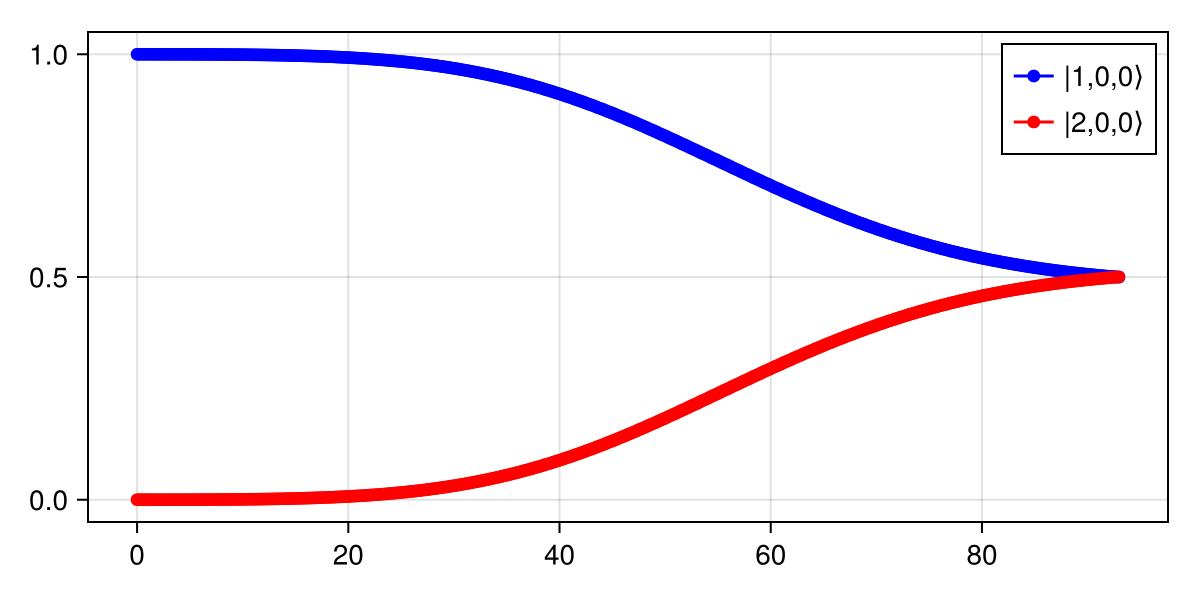

CairoMakie.Screen{IMAGE}


In [194]:
f = cm.Figure(size = (600, 300))
ax = cm.Axis(f[1, 1])

x = res_half_ef00["times"]
y = real.(EVs_Dict[(1,0,0)])
cm.scatterlines!(ax, x, y, color = :blue, label = "|1,0,0⟩")

x = res_half_ef00["times"]
y = real.(EVs_Dict[(2,0,0)])
cm.scatterlines!(ax, x, y, color = :red, label = "|2,0,0⟩")

cm.axislegend(ax, position = :rt)
display(f)

## Sidebands

#### Mode 3 Sidebands

##### Get Stark Shift

[2024-12-09 19:05:50] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:03:42


[2024-12-09 19:09:32] Info: Done With Floquet Sweep
[2024-12-09 19:09:32] Info: Fit Stuff: 3-element Vector{Float64}:	 0.03744821252807009	 0.002427553822387323	 2.1265305323631134


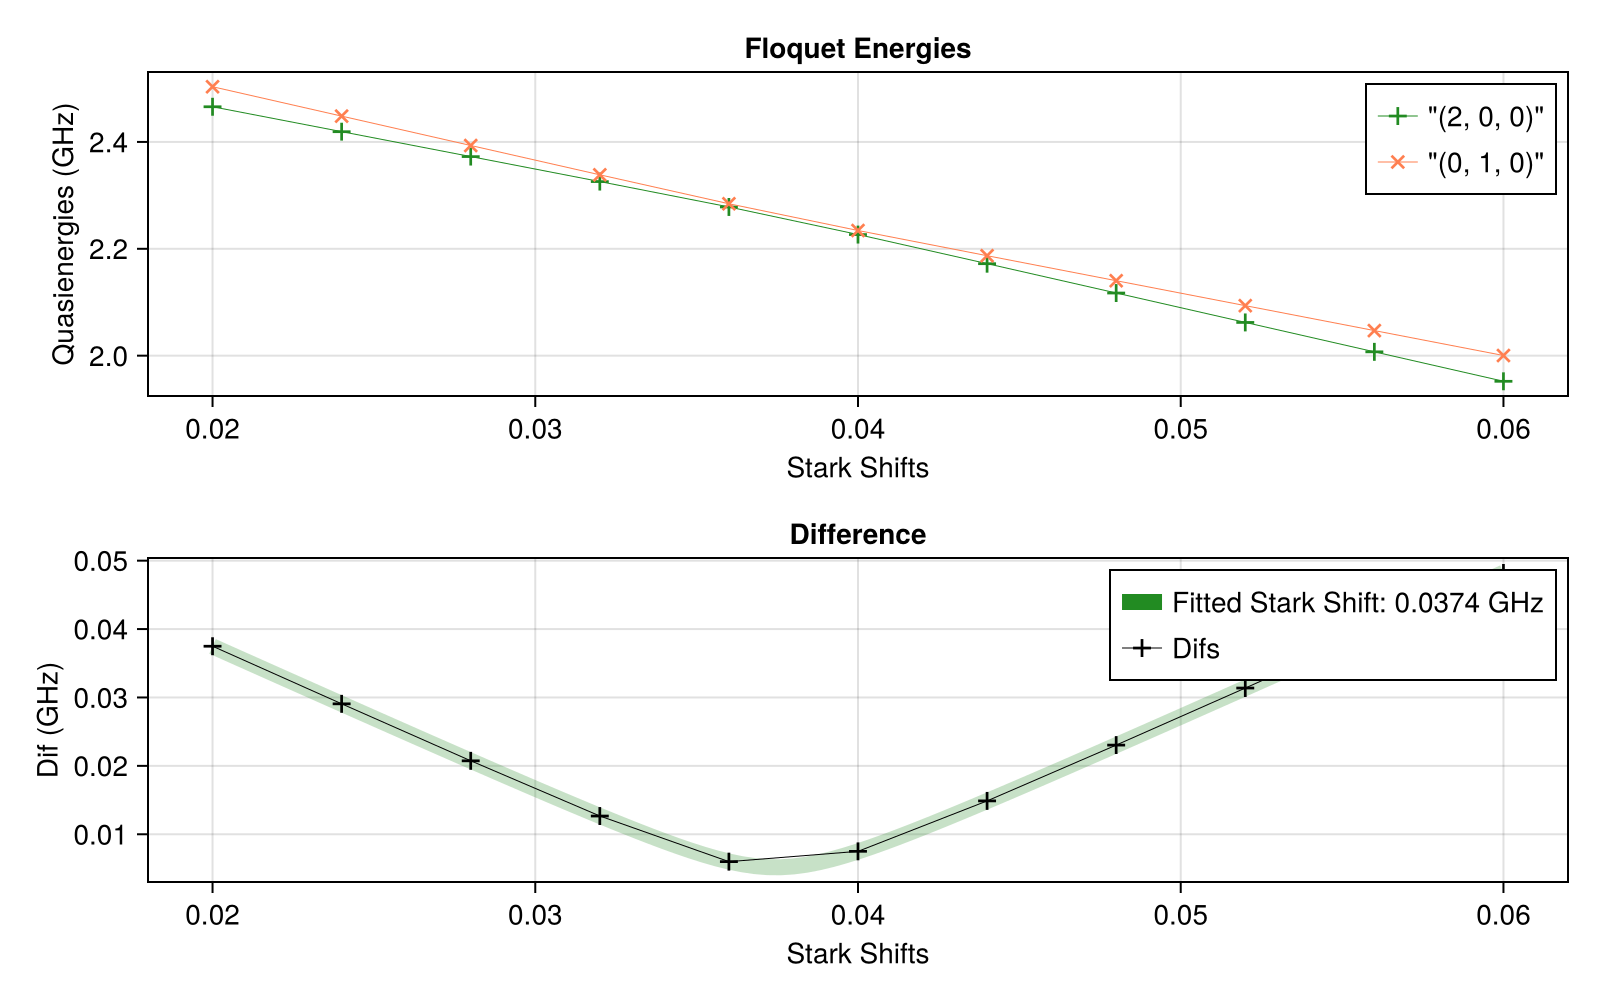

Stark shift res: [0.03744821252807009, 193.71333128907625]


In [148]:
Mode3_fngnp1_ε = 0.735
drive_op = Mode35.n̂ₜ
state1 = (2,0,0)
state2 = (0,1,0)

stark_shift_list = collect(LinRange(0.02, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode35, state1, state2, Mode3_fngnp1_ε, stark_shift_list)

println("Stark shift res: "*string(stark_shift_res))
Mode3_fngnp1_stark_shift = stark_shift_res[1];
Mode3_fngnp1_start_time = stark_shift_res[2];

In [149]:
Mode3_fngnp1_ramp_time = 11.6257;

##### $\ket{2,0,0}\to\ket{0,1,0}$

In [150]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][3][1]*1000))

Target flattop time: 181.36160714285714


In [151]:
state1 = (2,0,0)
state2 = (0,1,0)
ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2]-Mode35.dressed_energies[state1]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>Mode3_fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [Mode3_fngnp1_start_time, Mode3_fngnp1_start_time+Mode3_fngnp1_ramp_time*2]

optimize_res_Mode3_f0g1 = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, Mode3_fngnp1_ε, freq_d, Mode3_fngnp1_stark_shift, t_range, envelope, envelope_args, levels = 1)

[2024-12-09 19:09:33] Info: On Level 1
[2024-12-09 19:09:33] Info: On Step 1: t = 193.71333128907625
[2024-12-09 19:09:33] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 29s (ETA: 0h 00m 00s)
[2024-12-09 19:10:02] Info: Time Evolution Complete
[2024-12-09 19:10:02] Info: Done with Level_1_step_1
[2024-12-09 19:10:02] Info: Accurace: 0.989660809250361
[2024-12-09 19:10:02] Info: ------------------------------------------------------------------------------
[2024-12-09 19:10:02] Info: On Step 2: t = 199.52618128907625
[2024-12-09 19:10:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 30s (ETA: 0h 00m 00s)
[2024-12-09 19:10:33] Info: Time Evolution Complete
[2024-12-09 19:10:33] Info: Done with Level_1_step_2
[2024-12-09 19:10:33] Info: Accurace: 0.9968235873849545
[2024-12-09 19:10:33] Info: ------------------------------------------------------------------------------
[202

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 205.339
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>205.339, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0374482
  "accuracy"      => 0.999581
  "freq_d"        => -2.86712

In [152]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["sb_f0g1_Mode3"] = deepcopy(optimize_res_Mode3_f0g1)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 205.339
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>205.339, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0374482
  "accuracy"      => 0.999581
  "freq_d"        => -2.86712

##### $\ket{2,1,0}\to\ket{0,2,0}$

In [153]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][3][2]*1000))

Target flattop time: 125.55803571428572


In [154]:
state1 = (2,1,0)
state2 = (0,2,0)
ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2]-Mode35.dressed_energies[state1]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>Mode3_fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [Mode3_fngnp1_start_time/sqrt(2), Mode3_fngnp1_start_time/sqrt(2)+Mode3_fngnp1_ramp_time*2]

optimize_res_Mode3_f1g2 = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, Mode3_fngnp1_ε, freq_d, Mode3_fngnp1_stark_shift, t_range, envelope, envelope_args, levels = 1)

[2024-12-09 19:12:11] Info: On Level 1
[2024-12-09 19:12:11] Info: On Step 1: t = 136.97601016074202
[2024-12-09 19:12:11] Info: Running Time Evolution


Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 19s (ETA: 0h 00m 00s)
[2024-12-09 19:12:31] Info: Time Evolution Complete
[2024-12-09 19:12:31] Info: Done with Level_1_step_1
[2024-12-09 19:12:31] Info: Accurace: 0.979074167774162
[2024-12-09 19:12:31] Info: ------------------------------------------------------------------------------
[2024-12-09 19:12:31] Info: On Step 2: t = 142.78886016074202
[2024-12-09 19:12:31] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 21s (ETA: 0h 00m 00s)
[2024-12-09 19:12:52] Info: Time Evolution Complete
[2024-12-09 19:12:52] Info: Done with Level_1_step_2
[2024-12-09 19:12:52] Info: Accurace: 0.9932782415333192
[2024-12-09 19:12:52] Info: ------------------------------------------------------------------------------
[2024-12-09 19:12:52] Info: On Step 3: t = 148.60171016074202
[2024-12-09 19:12:52] Info: Running Time Evolution
Progress: [==============================] 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 148.602
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>148.602, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0374482
  "accuracy"      => 0.998736
  "freq_d"        => -2.86674

In [156]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["sb_f1g2_Mode3"] = deepcopy(optimize_res_Mode3_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 148.602
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>148.602, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0374482
  "accuracy"      => 0.998736
  "freq_d"        => -2.86674

#### Mode 5 Sidebands

##### Get Stark Shift

[2024-12-09 18:47:49] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:04:43


[2024-12-09 18:52:33] Info: Done With Floquet Sweep
[2024-12-09 18:52:33] Info: Fit Stuff: 3-element Vector{Float64}:	 0.04532374784914984	 0.0025233353825774222	 2.13844163164522


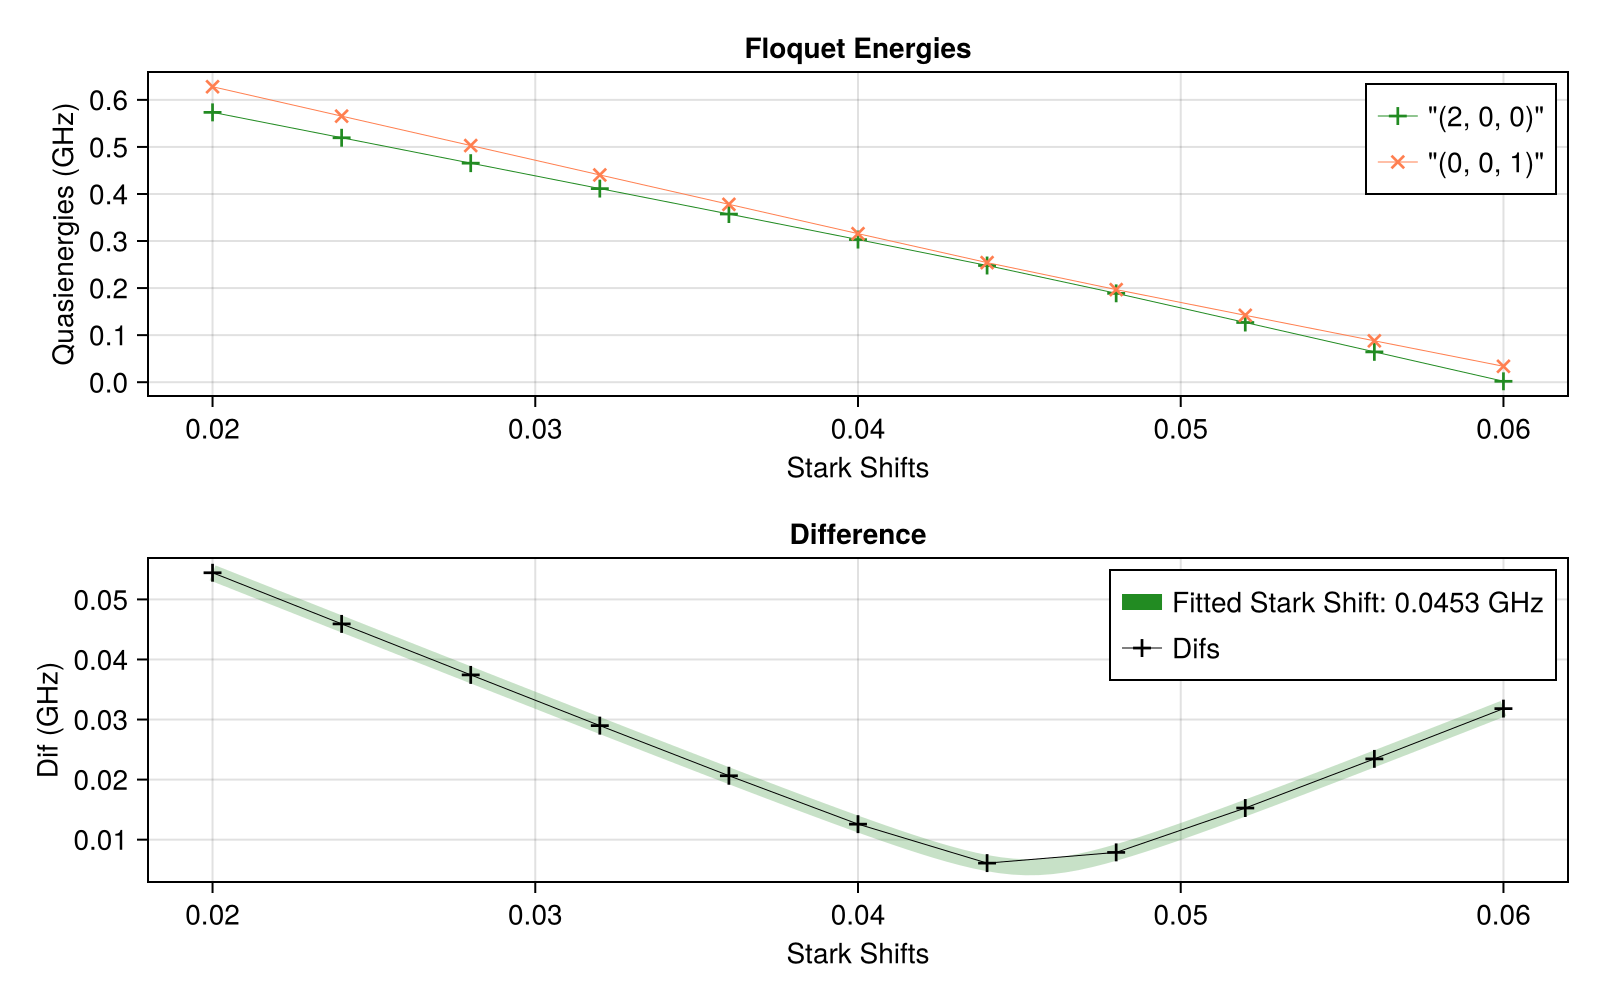

Stark shift res: [0.04532374784914984, 185.32227449933026]


In [ ]:
Mode5_fngnp1_ε = 1.21
drive_op = Mode35.n̂ₜ
state1 = (2,0,0)
state2 = (0,0,1)

stark_shift_list = collect(LinRange(0.02, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode35, state1, state2, Mode5_fngnp1_ε, stark_shift_list)

println("Stark shift res: "*string(stark_shift_res))
Mode5_fngnp1_stark_shift = stark_shift_res[1];
Mode5_fngnp1_start_time = stark_shift_res[2];

In [ ]:
Mode5_fngnp1_ramp_time = 11.6257;

##### $\ket{2,0,0}\to\ket{0,1,0}$

In [ ]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][5][1]*1000))

Target flattop time: 174.38616071428572


In [ ]:
state1 = (2,0,0)
state2 = (0,0,1)
ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2]-Mode35.dressed_energies[state1]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>Mode5_fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [Mode5_fngnp1_start_time, Mode5_fngnp1_start_time+Mode5_fngnp1_ramp_time*2]

optimize_res_Mode5_f0g1 = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, Mode5_fngnp1_ε, freq_d, Mode5_fngnp1_stark_shift, t_range, envelope, envelope_args, levels = 1)

[2024-12-09 18:52:43] Info: On Level 1
[2024-12-09 18:52:43] Info: On Step 1: t = 185.32227449933026
[2024-12-09 18:52:43] Info: Running Time Evolution


Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 27s (ETA: 0h 00m 00s)
[2024-12-09 18:53:11] Info: Time Evolution Complete
[2024-12-09 18:53:11] Info: Done with Level_1_step_1
[2024-12-09 18:53:11] Info: Accurace: 0.9892967465117406
[2024-12-09 18:53:11] Info: ------------------------------------------------------------------------------
[2024-12-09 18:53:11] Info: On Step 2: t = 191.1351244993303
[2024-12-09 18:53:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 29s (ETA: 0h 00m 00s)
[2024-12-09 18:53:40] Info: Time Evolution Complete
[2024-12-09 18:53:40] Info: Done with Level_1_step_2
[2024-12-09 18:53:40] Info: Accurace: 0.99684337065212
[2024-12-09 18:53:40] Info: ------------------------------------------------------------------------------
[2024-12-09 18:53:40] Info: On Step 3: t = 196.94797449933026
[2024-12-09 18:53:40] Info: Running Time Evolution
Progress: [==============================] 10

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 196.948
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>196.948, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0453237
  "accuracy"      => 0.999548
  "freq_d"        => -2.3746

In [ ]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["sb_f0g1_Mode5"] = deepcopy(optimize_res_Mode5_f0g1)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 196.948
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>196.948, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0453237
  "accuracy"      => 0.999548
  "freq_d"        => -2.3746

##### $\ket{2,1,0}\to\ket{0,2,0}$

In [ ]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][5][2]*1000))

Target flattop time: 123.2328869047619


In [ ]:
state1 = (2,0,1)
state2 = (0,0,2)
ψ1 = Mode35.dressed_states[state1]
ψ2 = Mode35.dressed_states[state2]

freq_d = Mode35.dressed_energies[state2]-Mode35.dressed_energies[state1]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>Mode5_fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [Mode5_fngnp1_start_time/sqrt(2), Mode5_fngnp1_start_time/sqrt(2)+Mode5_fngnp1_ramp_time*2]

optimize_res_Mode5_f1g2 = SC.Dynamics.OptimizePulse(Mode35, ψ1, ψ2, Mode5_fngnp1_ε, freq_d, Mode5_fngnp1_stark_shift, t_range, envelope, envelope_args, levels = 1)

[2024-12-09 18:55:15] Info: On Level 1
[2024-12-09 18:55:15] Info: On Step 1: t = 131.0426370033912
[2024-12-09 18:55:15] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 20s (ETA: 0h 00m 00s)
[2024-12-09 18:55:36] Info: Time Evolution Complete
[2024-12-09 18:55:36] Info: Done with Level_1_step_1
[2024-12-09 18:55:36] Info: Accurace: 0.9776931219013868
[2024-12-09 18:55:36] Info: ------------------------------------------------------------------------------
[2024-12-09 18:55:36] Info: On Step 2: t = 136.8554870033912
[2024-12-09 18:55:36] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 20s (ETA: 0h 00m 00s)
[2024-12-09 18:55:57] Info: Time Evolution Complete
[2024-12-09 18:55:57] Info: Done with Level_1_step_2
[2024-12-09 18:55:57] Info: Accurace: 0.9929069862813725
[2024-12-09 18:55:57] Info: ------------------------------------------------------------------------------
[2024

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 142.668
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>142.668, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0453237
  "accuracy"      => 0.998511
  "freq_d"        => -2.37426

In [ ]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode35.Stuff["op_drive_params"]["sb_f1g2_Mode5"] = deepcopy(optimize_res_Mode5_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 142.668
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>142.668, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.21
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0453237
  "accuracy"      => 0.998511
  "freq_d"        => -2.37426

# Some Pulse Sequences

## Noon States

### $|0,0,0\rangle \to |0,1,0\rangle + |0,0,1\rangle$

In [210]:
Mode35.Stuff["op_drive_params"]

Dict{String, Any} with 19 entries:
  "q_ge_10"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "sb_f0g1_Mode3" => Dict{String, Any}("pulse_time"=>205.339, "Envelope Args"=>…
  "sb_f0g1_Mode5" => Dict{String, Any}("pulse_time"=>196.948, "Envelope Args"=>…
  "q_ge_12"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "sb_f1g2_Mode3" => Dict{String, Any}("pulse_time"=>148.602, "Envelope Args"=>…
  "q_ef_00"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "q_ef_10"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "q_half_ef_00"  => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "q_ge_11"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "q_ge_01"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "q_ge_22"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "q_ef_11"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Ar

In [211]:
prep1 = ["q_ge_00", "q_half_ef_00", "sb_f0g1_Mode3", "q_ef_00", "sb_f0g1_Mode5"]

5-element Vector{String}:
 "q_ge_00"
 "q_half_ef_00"
 "sb_f0g1_Mode3"
 "q_ef_00"
 "sb_f0g1_Mode5"

In [254]:
#Mode35.Stuff["drive_sequences"]["NooN_1"] = prep1

#### Running Sequence

In [225]:
ψi = Mode35.dressed_states[(0, 0,0)]#+Mode5.dressed_states[(1,0)]
ψi = ψi/qt.norm(ψi)
res_prep1 = SC.Dynamics.RunPulseSequence(Mode35, ψi, prep1, Return = true, clean_up = true, spns = 2)

The Name for this run is: Operator_Sequence_Tue-Dec-10-24.16.16
It is being saved at: Data/
[2024-12-10 16:16:21] Info: Running operator q_ge_00
[2024-12-10 16:16:21] Info: Running Time Evolution


Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 12s (ETA: 0h 00m 00s)
[2024-12-10 16:16:33] Info: Time Evolution Complete
[2024-12-10 16:16:33] Info: Saving Steps
[2024-12-10 16:16:34] Info: Done with Step_1
[2024-12-10 16:16:34] Info: Running operator q_half_ef_00
[2024-12-10 16:16:34] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 12s (ETA: 0h 00m 00s)
[2024-12-10 16:16:47] Info: Time Evolution Complete
[2024-12-10 16:16:47] Info: Saving Steps
[2024-12-10 16:16:47] Info: Done with Step_2
[2024-12-10 16:16:47] Info: Running operator sb_f0g1_Mode3
[2024-12-10 16:16:47] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 29s (ETA: 0h 00m 00s)
[2024-12-10 16:17:17] Info: Time Evolution Complete
[2024-12-10 16:17:17] Info: Saving Steps
[2024-12-10 16:17:17] Info: Done with Step_3
[2024-12-10 16:17:17] Info: Running operator q_ef_00
[2024-12-10 16:17:17] I

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.499832, 0.999664, 1.4995, 1.99933, 2.49916, 2.99899, 3…
  "states" => Any[Quantum Object:   type=Ket   dims=[8, 6, 6]   size=(288,)…

#### Making Plot

In [227]:
EVs_prep1 = SC.Utils.Get_EVs(res_prep1["states"], proj_dict);

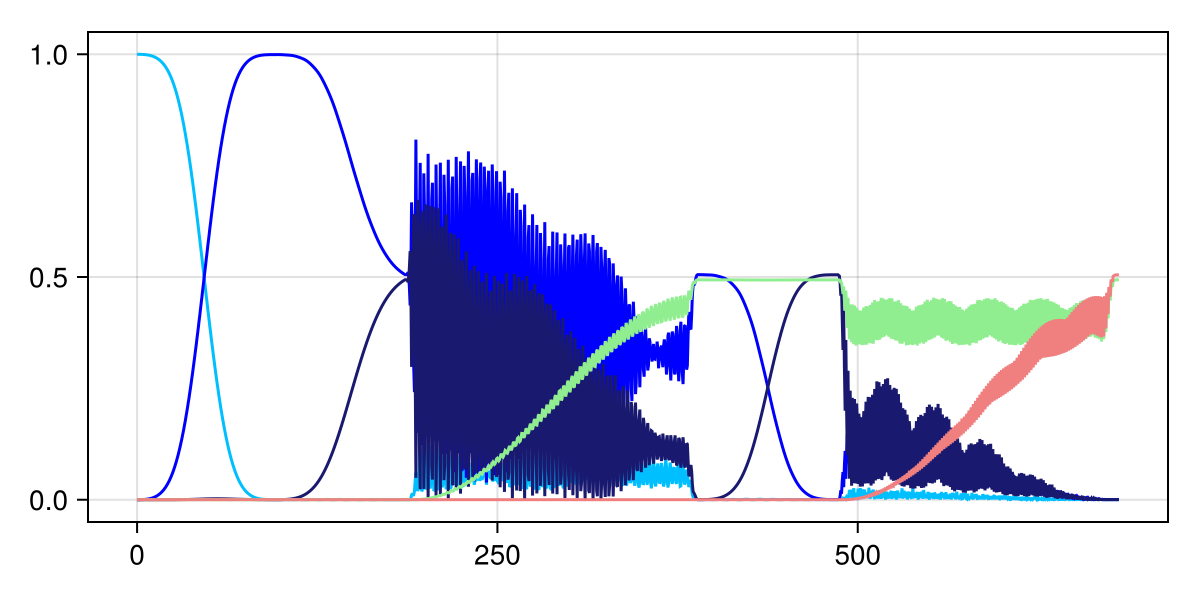

CairoMakie.Screen{IMAGE}


In [228]:
fig = cm.Figure(size = (600, 300))
ax = cm.Axis(fig[1, 1])

res = res_prep1
EVs = EVs_prep1

x = res["times"]
y = real.(EVs[(0,0,0)])
cm.lines!(x, y, color = "deepskyblue", label = "|0,0,0⟩")
y = real.(EVs[(1,0,0)])
cm.lines!(x, y, color = "blue", label = "|1,0,0⟩")
y = real.(EVs[(2,0,0)])
cm.lines!(x, y, color = "midnightblue", label = "|1,0,0⟩")

y = real.(EVs[(0,1,0)])
cm.lines!(x, y, color = "lightgreen", label = "|0,1,0⟩")
y = real.(EVs[(0,0,1)])
cm.lines!(x, y, color = "lightcoral", label = "|0,0,1⟩")


display(fig)

### $|0,0,0\rangle \to |0,2,0\rangle + |0,0,2\rangle$

In [224]:
Mode35.Stuff["op_drive_params"]

Dict{String, Any} with 19 entries:
  "q_ge_10"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "sb_f0g1_Mode3" => Dict{String, Any}("pulse_time"=>205.339, "Envelope Args"=>…
  "sb_f0g1_Mode5" => Dict{String, Any}("pulse_time"=>196.948, "Envelope Args"=>…
  "q_ge_12"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "sb_f1g2_Mode3" => Dict{String, Any}("pulse_time"=>148.602, "Envelope Args"=>…
  "q_ef_00"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "q_ef_10"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "q_half_ef_00"  => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "q_ge_11"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "q_ge_01"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "q_ge_22"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>…
  "q_ef_11"       => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Ar

In [229]:
prep2 = ["q_ge_00", "q_half_ef_00", "sb_f0g1_Mode3", "q_ef_00", "q_ge_10", "sb_f0g1_Mode5", "q_ef_11", "q_ge_11", "sb_f1g2_Mode3", "q_ef_21", "sb_f1g2_Mode5"]

11-element Vector{String}:
 "q_ge_00"
 "q_half_ef_00"
 "sb_f0g1_Mode3"
 "q_ef_00"
 "q_ge_10"
 "sb_f0g1_Mode5"
 "q_ef_11"
 "q_ge_11"
 "sb_f1g2_Mode3"
 "q_ef_21"
 "sb_f1g2_Mode5"

In [ ]:
#Mode35.Stuff["drive_sequences"]["NooN_2"] = prep2

11-element Vector{String}:
 "q_ge_00"
 "q_half_ef_00"
 "sb_f0g1_Mode3"
 "q_ef_00"
 "q_ge_10"
 "sb_f0g1_Mode5"
 "q_ef_11"
 "q_ge_11"
 "sb_f1g2_Mode3"
 "q_ef_21"
 "sb_f1g2_Mode5"

#### Running Sequence

In [257]:
ψi = Mode35.dressed_states[(0, 0,0)]#+Mode5.dressed_states[(1,0)]
ψi = ψi/qt.norm(ψi)
res_prep2 = SC.Dynamics.RunPulseSequence(Mode35, ψi, prep2, Return = true, clean_up = true, spns = "Stroboscopic")

The Name for this run is: Operator_Sequence_Wed-Dec-11-24.16.13
It is being saved at: Data/
[2024-12-11 16:13:08] Info: Running operator q_ge_00
[2024-12-11 16:13:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 12s (ETA: 0h 00m 00s)
[2024-12-11 16:13:20] Info: Time Evolution Complete
[2024-12-11 16:13:20] Info: Saving Steps
[2024-12-11 16:13:21] Info: Done with Step_1
[2024-12-11 16:13:21] Info: Running operator q_half_ef_00
[2024-12-11 16:13:21] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 13s (ETA: 0h 00m 00s)
[2024-12-11 16:13:34] Info: Time Evolution Complete
[2024-12-11 16:13:34] Info: Saving Steps
[2024-12-11 16:13:35] Info: Done with Step_2
[2024-12-11 16:13:35] Info: Running operator sb_f0g1_Mode3
[2024-12-11 16:13:35] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 29s (ETA: 0h 00m 00s)
[2024-12-11 16:14:

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.2173, 0.4345, 0.6518, 0.8691, 1.0864, 1.3036, 1.5209, 1.738…
  "states" => Any[Quantum Object:   type=Ket   dims=[8, 6, 6]   size=(288,)…

#### Making Plot

In [231]:
EVs_prep2 = SC.Utils.Get_EVs(res_prep2["states"], proj_dict);

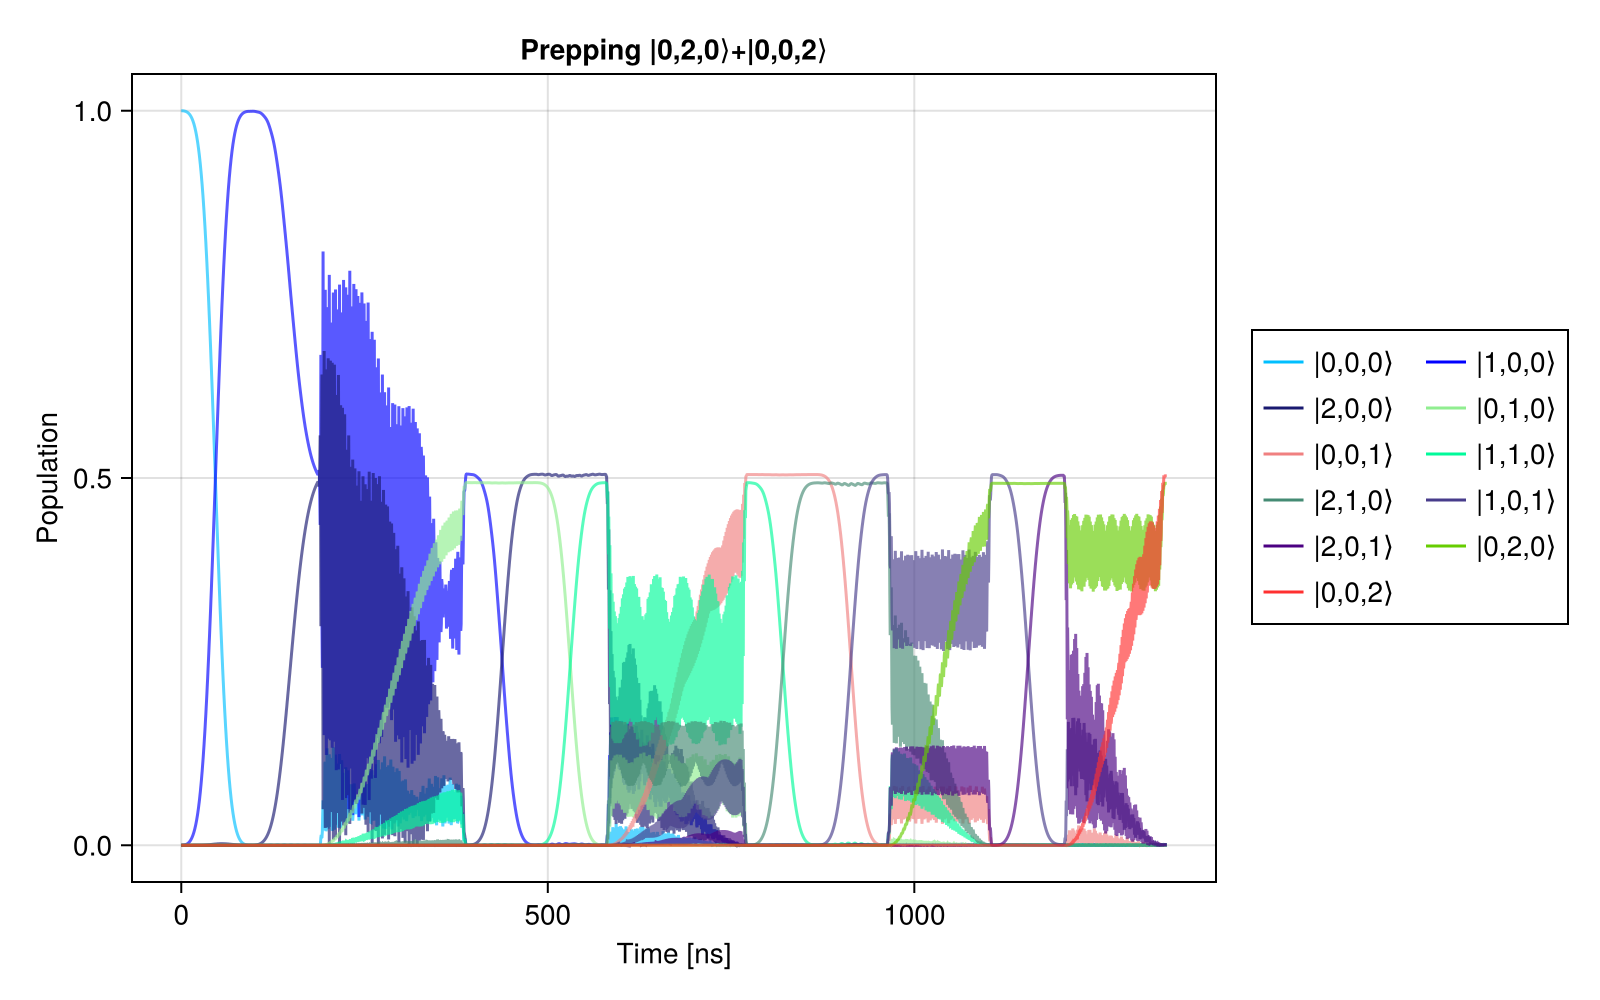

CairoMakie.Screen{IMAGE}


In [249]:
fig = cm.Figure(size = (800, 500))
ax = cm.Axis(fig[1, 1], xlabel = "Time [ns]", ylabel = "Population", title = "Prepping |0,2,0⟩+|0,0,2⟩")

res = res_prep2
EVs = EVs_prep2

alpha = 0.65
x = res["times"]
y = real.(EVs[(0,0,0)])
cm.lines!(x, y, color = "deepskyblue", label = "|0,0,0⟩", alpha = alpha)
y = real.(EVs[(1,0,0)])
cm.lines!(x, y, color = "blue", label = "|1,0,0⟩", alpha = alpha)
y = real.(EVs[(2,0,0)])
cm.lines!(x, y, color = "midnightblue", label = "|2,0,0⟩", alpha = alpha)

y = real.(EVs[(0,1,0)])
cm.lines!(x, y, color = "lightgreen", label = "|0,1,0⟩", alpha = alpha)
y = real.(EVs[(0,0,1)])
cm.lines!(x, y, color = "lightcoral", label = "|0,0,1⟩", alpha = alpha)

y = real.(EVs[(1,1,0)])
cm.lines!(x, y, color = "mediumspringgreen", label = "|1,1,0⟩", alpha = alpha)
y = real.(EVs[(2,1,0)])
cm.lines!(x, y, color = "aquamarine4", label = "|2,1,0⟩", alpha = alpha)


y = real.(EVs[(1,0,1)])
cm.lines!(x, y, color = "slateblue4", label = "|1,0,1⟩", alpha = alpha)
y = real.(EVs[(2,0,1)])
cm.lines!(x, y, color = "indigo", label = "|2,0,1⟩", alpha = alpha)


y = real.(EVs[(0,2,0)])
cm.lines!(x, y, color = "chartreuse3", label = "|0,2,0⟩", alpha = alpha)
y = real.(EVs[(0,0,2)])
cm.lines!(x, y, color = "firebrick1", label = "|0,0,2⟩", alpha = alpha)

cm.Legend(fig[1,2],ax, position = :rt, nbanks = 2)

display(fig)

In [256]:
println(EVs_prep2[(0,0,2)][end])
println(EVs_prep2[(0,2,0)][end])

0.5029424863366742 + 9.301475285126102e-19im
0.49281442289951916 + 6.49275770129971e-19im
